## **Proyecto Integrador Python Analytics**
### **Estudiante: Martín A. García Romano**
#### Abril 2023
# ***Predictor de resultados en partidos de Campeonatos Mundiales***

In [1]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import csv

# **Recolección de datos.**
### ***Importación del archivo csv con los datos en bruto.***

In [2]:
if os.access('partidos_mundiales_magr.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/MAGarciaRomano/Inove_PythonAnalytics_ProyIntegrador/main/partidos_mundiales_magr.csv > partidos_mundiales_magr.csv
    else:
        !wget partidos_mundiales_magr.csv https://raw.githubusercontent.com/MAGarciaRomano/Inove_PythonAnalytics_ProyIntegrador/main/partidos_mundiales_magr.csv

--2023-04-07 00:02:27--  http://partidos_mundiales_magr.csv/
Resolving partidos_mundiales_magr.csv (partidos_mundiales_magr.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘partidos_mundiales_magr.csv’
--2023-04-07 00:02:27--  https://raw.githubusercontent.com/MAGarciaRomano/Inove_PythonAnalytics_ProyIntegrador/main/partidos_mundiales_magr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121396 (119K) [text/plain]
Saving to: ‘partidos_mundiales_magr.csv’

partidos_mundiales_ 100%[===================>] 118.55K  --.-KB/s    in 0.02s   

2023-04-07 00:02:27 (4.74 MB/s) - ‘partidos_mundiales_magr.csv’ saved [121396/121396]

FINISHED --2023-04-07 00:02:27--
Total wall clock time: 0.3s
Downloaded: 1 files, 119K in 0.02s (4.74 MB/

# **Procesamientos de Datos.**
### ***Estadística de los datos.***

In [3]:
# Descripción estadística del dataframe.
dataframe = pd.read_csv("partidos_mundiales_magr.csv")
descripcion = dataframe.describe()
descripcion.loc['Nan'] = dataframe.isna().sum()
descripcion.loc['%Nan'] = (dataframe.isna().mean())*100
descripcion

,Goles L,Goles V
count,964.000000,964.000000
mean,1.894191,1.159751
std,1.673571,1.225126
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,10.000000,7.000000
Nan,0.000000,0.000000
%Nan,0.000000,0.000000


In [4]:
dataframe.head()

,Torneo,Fase y Grupo,Fecha,Estadio/Ciudad,Local,Goles L,Visita,Goles V,Observaciones,Resultado
0,Uruguay 1930,"Primera, Grupo A",13 de julio de 1930,"Pocitos, Montevideo",Francia,4,México,1,PT 3 a 0,Local
1,Uruguay 1930,"Primera, Grupo D",13 de julio de 1930,"Parque Central, Montevideo",Estados Unidos,3,Bélgica,0,PT 2 a 0,Local
2,Uruguay 1930,"Primera, Grupo B",14 de julio de 1930,"Parque Central, Montevideo",Yugoslavia,2,Brasil,1,PT 2 a 0,Local
3,Uruguay 1930,"Primera, Grupo C",14 de julio de 1930,"Pocitos, Montevideo",Rumania,3,Perú,1,PT 1 a 0,Local
4,Uruguay 1930,"Primera, Grupo A",15 de julio de 1930,"Parque Central, Montevideo",Argentina,1,Francia,0,PT 0 a 0,Local


In [5]:
# Exploración del dataset para contabilizar partidos ganados por el local, por el visitante o empatados.
dataframe['Resultado'].value_counts()

Local     552
Visita    232
Empate    180
Name: Resultado, dtype: int64

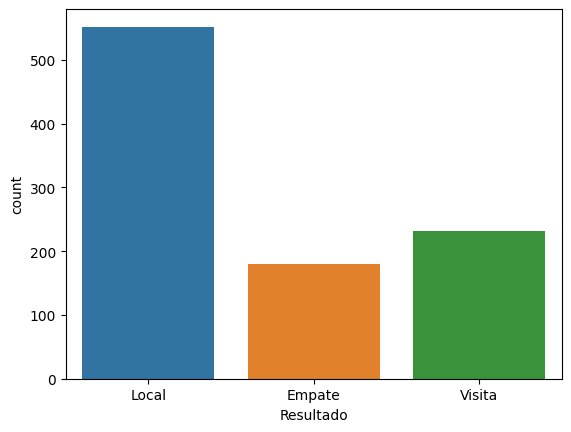

In [6]:
# Gráfico de barras mostrando el total de cada uno de los resultados posibles.
ax = sns.countplot(data=dataframe, x="Resultado")

Tanto la exploración del dataset como el gráfico muestran que en la distribución de los tres resultado finales posibles hay un claro predominio de los partidos ganados por el local (57,26%) sobre los que terminaron ganados por la visita (24,07%) o en empate (18,67%).

In [7]:
# Visualización de la organización de los datos para saber el número de filas y columnas del dataset.
print('Organización de datos para analizar (filas y columnas):', dataframe.shape)

Organización de datos para analizar (filas y columnas): (964, 10)


# ***Entrenamiento de los modelos.***

### ***Preparación del dataset.***
Se listan las columnas del dataframe.
Se crea una copia del dataframe.
Se eliminan en la copia del dataframe las columnas Torneo, Fase y Grupo, Fecha, Estadio/Ciudad, Goles L, Goles V y Observaciones.

In [8]:
# Listado de los encabezados de las columnas.
list(dataframe.columns)

['Torneo',
 'Fase y Grupo',
 'Fecha',
 'Estadio/Ciudad',
 'Local',
 'Goles L',
 'Visita',
 'Goles V',
 'Observaciones',
 'Resultado']

Las columnas necesarias son las que contienen las selecciones que jugaron el partido (Local y Visita) y la determinación de si el partido fue ganado por el local, por la visita o fue empate (Resultado).

In [9]:
# Creación de una copia del dataframe original.
# Sobre esa copia se operaran los cambios.
# Eliminación de las columnas no necesarias.
dataframe_limpio = dataframe.copy()
dataframe_limpio.drop(['Torneo', 'Fase y Grupo', 'Fecha', 'Estadio/Ciudad', 'Goles L', 'Goles V', 'Observaciones'], axis= 'columns' , inplace=True)

In [10]:
# Se visualiza el encabezado del dataframe generado: dataframe_limpio.
dataframe_limpio.head()

,Local,Visita,Resultado
0,Francia,México,Local
1,Estados Unidos,Bélgica,Local
2,Yugoslavia,Brasil,Local
3,Rumania,Perú,Local
4,Argentina,Francia,Local


#### ***Creación de un vector que contenga todos los elementos de las columnas Local y Visitante.***

In [11]:
# Se genera un vector para cada columna.
# En cada vector se cuentan los registros únicos.
# Se muestra el resultado de la última operación mencionada. 
vector_local_todos = dataframe_limpio['Local']
vector_local_unicos = vector_local_todos.unique()
print('Total de selecciones en la columna Local:', len(vector_local_unicos))
vector_visita_todos = dataframe_limpio['Visita']
vector_visita_unicos = vector_visita_todos.unique()
print('Total de selecciones en la columna Visita:', len(vector_visita_unicos))

Total de selecciones en la columna Local: 80
Total de selecciones en la columna Visita: 86


In [12]:
# A partir de los dos vectores se crea un vector único.
vector_todos = pd.concat([dataframe_limpio['Local'], dataframe_limpio['Visita']])
vector_todos

0             Francia
1      Estados Unidos
2          Yugoslavia
3             Rumania
4           Argentina
            ...      
959        Inglaterra
960           Croacia
961         Marruecos
962         Marruecos
963           Francia
Length: 1928, dtype: object

In [13]:
# A partir del vector anterior se crea otro que contiene sólo sus elementos únicos y los cuenta.
# Se muestra el vector.
vector_selecciones = vector_todos.unique()
print('Total de selecciones en todos los mundiales:', len(vector_selecciones))
vector_selecciones

Total de selecciones en todos los mundiales: 86


array(['Francia', 'Estados Unidos', 'Yugoslavia', 'Rumania', 'Argentina',
       'Chile', 'Uruguay', 'Brasil', 'Paraguay', 'Hungría', 'España',
       'Suecia', 'Suiza', 'Checoslovaquia', 'Alemania', 'Italia',
       'Austria', 'Cuba', 'Inglaterra', 'Alemania Occidental', 'Turquía',
       'Irlanda del Norte', 'Unión Soviética', 'México', 'Gales',
       'Portugal', 'Corea del Norte', 'Perú', 'Bélgica', 'Bulgaria',
       'Alemania Oriental', 'Zaire', 'Polonia', 'Australia', 'Escocia',
       'Países Bajos', 'Haití', 'Túnez', 'Argelia', 'Honduras', 'Canadá',
       'Marruecos', 'Corea del Sur', 'Iraq', 'Dinamarca',
       'Emiratos Árabes Unidos', 'Costa Rica', 'Camerún', 'Irlanda',
       'Colombia', 'Noruega', 'Nigeria', 'Arabia Saudita', 'Bolivia',
       'Rusia', 'Grecia', 'Jamaica', 'Sudáfrica', 'Japón', 'Croacia',
       'China', 'Senegal', 'Eslovenia', 'Ecuador', 'Trinidad y Tobago',
       'Serbia y Montenegro', 'Angola', 'República Checa', 'Togo',
       'Costa de Marfil', 'Ir

In [14]:
# Se ordena el vector alfabeticamente.
vector_selecciones.sort()
vector_selecciones

array(['Alemania', 'Alemania Occidental', 'Alemania Oriental', 'Angola',
       'Arabia Saudita', 'Argelia', 'Argentina', 'Australia', 'Austria',
       'Bolivia', 'Bosnia-Herzegovina', 'Brasil', 'Bulgaria', 'Bélgica',
       'Camerún', 'Canadá', 'Checoslovaquia', 'Chile', 'China',
       'Colombia', 'Corea del Norte', 'Corea del Sur', 'Costa Rica',
       'Costa de Marfil', 'Croacia', 'Cuba', 'Dinamarca', 'Ecuador',
       'Egipto', 'El Salvador', 'Emiratos Árabes Unidos', 'Escocia',
       'Eslovaquia', 'Eslovenia', 'España', 'Estados Unidos', 'Francia',
       'Gales', 'Ghana', 'Grecia', 'Haití', 'Honduras', 'Hungría',
       'Indias Holandesas', 'Inglaterra', 'Iraq', 'Irlanda',
       'Irlanda del Norte', 'Irán', 'Islandia', 'Israel', 'Italia',
       'Jamaica', 'Japón', 'Kuwait', 'Marruecos', 'México', 'Nigeria',
       'Noruega', 'Nueva Zelandia', 'Panamá', 'Paraguay', 'Países Bajos',
       'Países Bajos ', 'Perú', 'Polonia', 'Portugal', 'Qatar',
       'República Checa', 'Ruman

### ***Importación de herramientas de la librería SciKit.***

In [15]:
# Importación de Herramientas de Preporcesamiento:
  # LabelEncoder: codificación de labels de 0 a n, siendo 0 la primera y n la última.
  # OneHotEnconder: codificación a través de vectores con tantas columnas como features,
                  # donde a cada feature le corresponde una columna que se codifica con 1 y a las demás columnas se les asigna 0.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Importación de herramientas de selección:
  # train_set_split: para particionar un dataset en datos destinados a entrenamiento (train) y prueba (test).
from sklearn.model_selection import train_test_split

# Importación de herramientas de métricas.
  # confusion_matrix: generador de matrices de confusión.
  # ConfusionMatrixDisplay: para mostrar las matrices de confusión.
  # accuracy_score: para calcular la exactitud.
  # f1_score: para calcular el error de cada posible salida en el resultado.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Importación del clasificador.
from sklearn.ensemble import RandomForestClassifier

### ***Codificación por Label Encoder.***
### ***Clasificación por Random Forest Classifier.***

In [16]:
#from sklearn.preprocessing import LabelEncoder
labenc = LabelEncoder()

# Se aplica la codificación Label Encoding al vector vector_selecciones.
label_encoding = labenc.fit_transform(vector_selecciones.reshape(-1, 1))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# Se crea una copia del dataframe para modificar las columnas con label encoder.
dataframe_labenc = dataframe_limpio.copy()
# Se crea el objeto label encoding para la columna 'Local'
local_label_encoding = labenc.transform(dataframe_labenc['Local'])
# Se crea el objeto label encoding para la columna 'Visita'
visita_label_encoding = labenc.transform(dataframe_labenc['Visita'])
# Se crea la columna 'Local_LE' con la codificación label encoding.
dataframe_labenc.insert(1, 'Local_LE', local_label_encoding, True)
# Se crea la columna 'Visita_LE' con la codificación label encoding.
dataframe_labenc.insert(3, 'Visita_LE', visita_label_encoding, True)
# Se muestra el dataframe.
dataframe_labenc

,Local,Local_LE,Visita,Visita_LE,Resultado
0,Francia,36,México,56,Local
1,Estados Unidos,35,Bélgica,13,Local
2,Yugoslavia,84,Brasil,11,Local
3,Rumania,69,Perú,64,Local
4,Argentina,6,Francia,36,Local
...,...,...,...,...,...
959,Francia,36,Inglaterra,44,Local
960,Argentina,6,Croacia,24,Local
961,Francia,36,Marruecos,55,Local
962,Croacia,24,Marruecos,55,Local


In [18]:
# Se crea una copia del dataframe y en él se eliminan las columnas Local y Visita.
dataframe_labenc_limpio = dataframe_labenc.copy()
dataframe_labenc_limpio.drop(["Local", "Visita"], axis=1, inplace=True)
dataframe_labenc_limpio

,Local_LE,Visita_LE,Resultado
0,36,56,Local
1,35,13,Local
2,84,11,Local
3,69,64,Local
4,6,36,Local
...,...,...,...
959,36,44,Local
960,6,24,Local
961,36,55,Local
962,24,55,Local


In [19]:
# Se genera un numpy array "X" que posee los features Local_LE y Visita_LE (Se excluye Resultado).
# Se genera otro array numpy "y" con la columna Resultado solamente.
X = dataframe_labenc_limpio.drop('Resultado', axis=1).values
y = dataframe_labenc_limpio['Resultado'].values

In [20]:
# División del dataset en una parte para entrenamiento (70%) y otra para evaluación (30%).
# Se fija un "random_state" constante para que siempre el dataset se particione de la misma forma.
# De esa manera se pueden repetir los ensayos sin cambiar la distribución original de entrenamiento y evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Se crea el modelo base.
class RandomBaseModel():
    def __init__(self):
        self.classes_ = [0, 1]
    def fit(self,X, y):
        self.classes_ = np.unique(y)
        return None

    def predict(self,X):
        rand = np.random.randint(0, len(self.classes_), size=X.shape[0])
        rand_clases = [self.classes_[x] for x in rand]
        return np.asarray(rand_clases)

In [22]:
# Se obtienen las salidas según el modelo base anterior.
random_model = RandomBaseModel()
random_model.fit(X_train, y_train)
y_hat_base = random_model.predict(X_test)
random_model.classes_

array(['Empate', 'Local', 'Visita'], dtype=object)

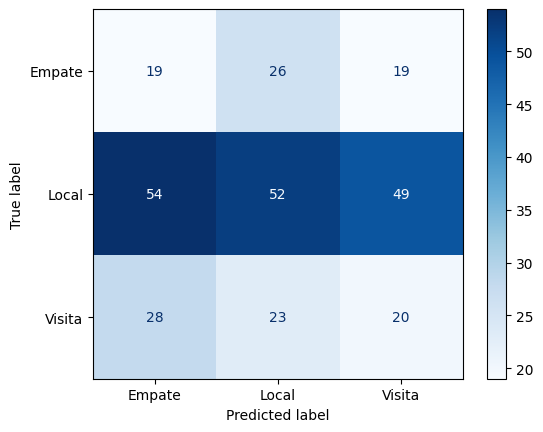

In [23]:
# Se compone la matriz de confusión para el modelo base, con y_test e y_hat_base.
cm = confusion_matrix(y_test, y_hat_base)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Empate', 'Local', 'Visita'])
cmd.plot(cmap=plt.cm.Blues)
plt.show()

In [24]:
# Calcular la exactitud (accuracy) del modelo base.
accuracy_score(y_test, y_hat_base, normalize=True)

0.3137931034482759

In [25]:
# Calcular el f1_score para cada posible resultado.
f1_score(y_test, y_hat_base, average=None)

array([0.23030303, 0.40625   , 0.25157233])

In [26]:
# Rutina para determinación de los valores de los parámetros n_estimators y max_depth que arrojan la mayor exactitud (accuracy).

# Para n_estimators se establece un rango que va de 1 a 100.
rango_estimadores = range(1, 100)

# Bucle para entrenar un modelo de clasificación RandomForest con cada valor de n_estimators.
# Dentro del bucle también se evalua max_depth con un rango de 0 a 5.
# Se establece una exactitud (accuracy) inicial de 0.
exactitud = 0
for n_estimadores in rango_estimadores:
    rango_profundidad =range(0, 6)    
    for n_profundidad in rango_profundidad:
      clf = RandomForestClassifier(n_estimators = n_estimadores, max_depth = n_profundidad, criterion = 'entropy', random_state = 0)
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    if exactitud < accuracy_score(y_test, y_hat, normalize=True):
      exactitud = accuracy_score(y_test, y_hat, normalize=True)
      estimador = n_estimadores
      profundo = n_profundidad
      print(exactitud, estimador, profundo)

print('La mayor exactitud es ', exactitud)
print('El número óptimo de estimadores es', estimador, 'con una profundidad de', profundo, '.')

0.5 1 5
0.506896551724138 2 5
0.5172413793103449 4 5
0.5275862068965518 5 5
0.5310344827586206 32 5
0.5344827586206896 36 5
La mayor exactitud es  0.5344827586206896
El número óptimo de estimadores es 36 con una profundidad de 5 .


In [27]:
# Se aplica el modelo Random Forest con los estimadores y profundidad optimizados.
clf_le = RandomForestClassifier(n_estimators= estimador, max_depth= profundo, criterion='entropy', random_state = 0)
clf_le.fit(X_train, y_train)
y_hat = clf_le.predict(X_test)
clf_le.classes_

array(['Empate', 'Local', 'Visita'], dtype=object)

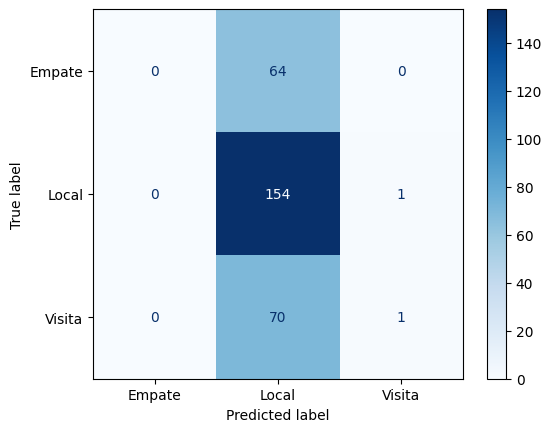

In [28]:
# Matriz de confusión del modelo con Random Forest y Label Encoding.
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=clf_le.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
# Calcular el f1_score para cada posible resultado.
f1_score(y_test, y_hat, average=None)

array([0.        , 0.69525959, 0.02739726])

### ***Utilización del modelo.***

In [30]:
# Ingreso de dos selecciones y predicción del resultado.
local = input('Ingrese el equipo local: ')
visita = input('Ingrese el equipo visitante: ')
print(local, 'vs.', visita)

# (Basado en el ejercicio de supervivencia en el Titanic.)
# Se aplica el encoder a los datos ingresados.
local_encoded = int(labenc.transform([local]))
visita_encoded = int(labenc.transform([visita]))
# Se crea el array de entrada.
X_prueba = np.array([local_encoded, visita_encoded])
# El sistema espera 1 fila y N columnas, hay que hacer reshape.
X_prueba = X_prueba.reshape(1, -1)
y_prueba = clf.predict(X_prueba)

if y_prueba == 'Local':
  print('Gana', local)
elif y_prueba == 'Visita':
  print('Gana', visita)
else:
  print(local, 'y', visita, 'empatan.')

Ingrese el equipo local: Austria
Ingrese el equipo visitante: Ucrania
Austria vs. Ucrania
Gana Austria


####**Guardado del dataframe como archivo csv y exportación del codificador y del modelo**.
##### *Label Encoder + Random Forest Classifier*

In [31]:
# Exportación del codificador Label Encoder.
pickle.dump(labenc, open('mundiales_labelencoder.pkl', 'wb'))
# Guardado como archivo csv del dataframe final codificado con Label Encoder.
dataframe_labenc_limpio.to_csv('mundiales_labelencoder.csv')
# Exportación del clasificador Random Forest Classifier.
pickle.dump(clf_le, open('mundiales_labelencoder_rfc.pkl', 'wb'))

### ***Codificación por One Hot Encoder***
### ***Clasificación por Random Forest Classifier***

In [32]:
# Se crea una copia del dataframe modificado con Label Encoding.
dataframe_ohe = dataframe_labenc.copy()

In [33]:
# Se visualiza el encabezado. 
dataframe_ohe.head()

,Local,Local_LE,Visita,Visita_LE,Resultado
0,Francia,36,México,56,Local
1,Estados Unidos,35,Bélgica,13,Local
2,Yugoslavia,84,Brasil,11,Local
3,Rumania,69,Perú,64,Local
4,Argentina,6,Francia,36,Local


In [34]:
# Implementación para One Hot Encoder.
def one_hot_encoding(df, column):
    df_copy = df.copy()
    # Entrenamiento del LabelEncoder.
    #labenc = LabelEncoder()
    label_encoding = labenc.fit_transform(df_copy[column])
    # Entrenamiento del OneHotEncoder.
    ohenc = OneHotEncoder(sparse=False)
    one_hot_encoding = ohenc.fit_transform(label_encoding.reshape(-1, 1))
    # Crear las columnas con el resultado del encoder
    one_hot_encoding_df = pd.DataFrame(one_hot_encoding, columns=labenc.classes_, dtype=int)
    # Agregar sufijo con nombre de la selección.
    one_hot_encoding_df = one_hot_encoding_df.add_prefix(column+'_')
    # Unir nuevas columnas al dataset.
    df_copy = df_copy.join(one_hot_encoding_df)
    # Eliminar viejas columnas del dataset.
    df_copy = df_copy.drop([column], axis=1)
    return df_copy, labenc, one_hot_encoding

In [35]:
dataframe_ohe, le_local, ohe_local = one_hot_encoding(dataframe_ohe, 'Local')
dataframe_ohe, le_visita, ohe_visita = one_hot_encoding(dataframe_ohe, 'Visita')

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
# Listado de las columnas del dataframe con la codificación One Hot Encoder.
list(dataframe_ohe.columns)

['Local_LE',
 'Visita_LE',
 'Resultado',
 'Local_Alemania',
 'Local_Alemania Occidental',
 'Local_Alemania Oriental',
 'Local_Angola',
 'Local_Arabia Saudita',
 'Local_Argelia',
 'Local_Argentina',
 'Local_Australia',
 'Local_Austria',
 'Local_Bolivia',
 'Local_Bosnia-Herzegovina',
 'Local_Brasil',
 'Local_Bulgaria',
 'Local_Bélgica',
 'Local_Camerún',
 'Local_Canadá',
 'Local_Checoslovaquia',
 'Local_Chile',
 'Local_China',
 'Local_Colombia',
 'Local_Corea del Norte',
 'Local_Corea del Sur',
 'Local_Costa Rica',
 'Local_Costa de Marfil',
 'Local_Croacia',
 'Local_Cuba',
 'Local_Dinamarca',
 'Local_Ecuador',
 'Local_Emiratos Árabes Unidos',
 'Local_Escocia',
 'Local_Eslovaquia',
 'Local_Eslovenia',
 'Local_España',
 'Local_Estados Unidos',
 'Local_Francia',
 'Local_Gales',
 'Local_Ghana',
 'Local_Grecia',
 'Local_Haití',
 'Local_Honduras',
 'Local_Hungría',
 'Local_Inglaterra',
 'Local_Iraq',
 'Local_Irlanda',
 'Local_Irlanda del Norte',
 'Local_Irán',
 'Local_Islandia',
 'Local_Italia

In [37]:
# Visualización del dataframe modificado.
dataframe_ohe

,Local_LE,Visita_LE,Resultado,Local_Alemania,Local_Alemania Occidental,Local_Alemania Oriental,Local_Angola,Local_Arabia Saudita,Local_Argelia,Local_Argentina,...,Visita_Suiza,Visita_Togo,Visita_Trinidad y Tobago,Visita_Turquía,Visita_Túnez,Visita_Ucrania,Visita_Unión Soviética,Visita_Uruguay,Visita_Yugoslavia,Visita_Zaire
0,36,56,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35,13,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,84,11,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,69,64,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,36,Local,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,36,44,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
960,6,24,Local,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
961,36,55,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962,24,55,Local,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Creación de una copia del dataframe sin las columnas Local_LE, Visita_LE.
dataframe_ohe_limpio = dataframe_ohe.copy()
dataframe_ohe_limpio.drop(["Local_LE", "Visita_LE"], axis = 1, inplace= True)
dataframe_ohe_limpio

,Resultado,Local_Alemania,Local_Alemania Occidental,Local_Alemania Oriental,Local_Angola,Local_Arabia Saudita,Local_Argelia,Local_Argentina,Local_Australia,Local_Austria,...,Visita_Suiza,Visita_Togo,Visita_Trinidad y Tobago,Visita_Turquía,Visita_Túnez,Visita_Ucrania,Visita_Unión Soviética,Visita_Uruguay,Visita_Yugoslavia,Visita_Zaire
0,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Local,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
960,Local,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
961,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962,Local,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Se reorganizan las columnas pasando la columna Resultado a la última posición (extremo derecha).
columna = dataframe_ohe_limpio.pop('Resultado')
dataframe_ohe_limpio.insert(loc= 166 , column= 'Resultado', value= columna)
dataframe_ohe_limpio

,Local_Alemania,Local_Alemania Occidental,Local_Alemania Oriental,Local_Angola,Local_Arabia Saudita,Local_Argelia,Local_Argentina,Local_Australia,Local_Austria,Local_Bolivia,...,Visita_Togo,Visita_Trinidad y Tobago,Visita_Turquía,Visita_Túnez,Visita_Ucrania,Visita_Unión Soviética,Visita_Uruguay,Visita_Yugoslavia,Visita_Zaire,Resultado
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
960,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local
962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Local


In [40]:
# Se cuenta el número de columnas del dataset.
print('Número de columnas:', dataframe_ohe_limpio.shape[1])

Número de columnas: 167


Nota:
Puede verse que el número de columnas (clases) excede por mucho las 15 a 20 que como máximo se recomiendan en los apuntes del curso.

In [41]:
# Se genera un numpy array "X" que posee los features con los prefijos Local_ y Visita_ (Se excluye Resultado).
# Se genera otro array numpy "y" con la columna Resultado solamente.
X = dataframe_ohe_limpio.drop('Resultado', axis=1).values
y = dataframe_ohe_limpio['Resultado'].values

In [42]:
# División del dataset en una parte para entrenamiento (70%) y evaluación (30%)
# Se fija un "random_state" constante para que siempre el dataset se parta de la misma forma.
# De esa manera se pueden repetir los ensayos sin cambiar la distribución original de entrenamiento y evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
# Rutina para determinación de los valores de los parámetros n_estimators y max_depth que arrojan la mejor accuracy.

# Para n_estimators se establece un rango de estimadores de 1 a 100.
rango_estimadores = range(1, 100)

# Bucle para entrenar un modelo de clasificación RandomForest con cada valor de n_estimators.
# Dentro del bucle también se evalua max_depth con un rango de 0 a 5.
# Se establece una accuracy (exactitud) inicial de 0.
exactitud = 0
for n_estimadores in rango_estimadores:
    rango_profundidad =range(0, 6)    
    for n_profundidad in rango_profundidad:
      clf = RandomForestClassifier(n_estimators = n_estimadores, max_depth = n_profundidad, criterion = 'entropy', random_state = 0)
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    if exactitud < accuracy_score(y_test, y_hat, normalize=True):
      exactitud = accuracy_score(y_test, y_hat, normalize=True)
      estimador = n_estimadores
      profundo = n_profundidad
      print(exactitud, estimador, profundo)

print('La mayor exactitud es ', exactitud)
print('El número óptimo de estimadores es', estimador, 'con una profundidad de', profundo, '.')

0.5310344827586206 1 5
0.5379310344827586 6 5
La mayor exactitud es  0.5379310344827586
El número óptimo de estimadores es 6 con una profundidad de 5 .


In [44]:
# Se aplica el modelo Random Forest con los estimadores y profundidad optimizados.
clf_ohe = RandomForestClassifier(n_estimators=estimador, max_depth=profundo, criterion='entropy', random_state = 0)
clf_ohe.fit(X_train, y_train)
y_hat = clf_ohe.predict(X_test)

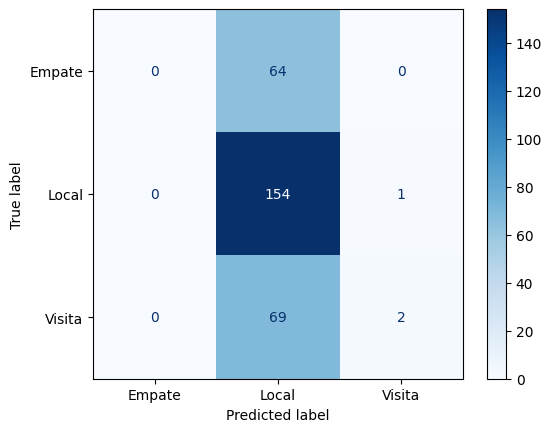

In [45]:
# Matriz de confusión del modelo con Random Forest y One Hot Encoding.
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=clf_ohe.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

In [46]:
# Calcular el f1_score para cada posible resultado.
f1_score(y_test, y_hat, average=None)

array([0.        , 0.69683258, 0.05405405])

#### **Guardado del dataframe como archivo csv y exportación del modelo**.
##### *One Hot Encoder + Random Forest Classifier*

In [47]:
# Guardado como archivo csv del dataframe final codificado con One Hot Encoder.
dataframe_ohe_limpio.to_csv('mundiales_onehotencoder.csv')
# Exportación del clasificador Random Forest Classifier.
pickle.dump(clf_ohe, open('mundiales_onehotencoder_rfc.pkl', 'wb'))

### ***Codificación por Binary Encoder.***
### ***Clasificación por Random Fores Classifier.***

In [48]:
# Se crea una copia del dataframe modificado con label encoder.
dataframe_be = dataframe_limpio.copy()

In [49]:
# Se visualiza el encabezado del dataframe.
dataframe_be.head()

,Local,Visita,Resultado
0,Francia,México,Local
1,Estados Unidos,Bélgica,Local
2,Yugoslavia,Brasil,Local
3,Rumania,Perú,Local
4,Argentina,Francia,Local


In [50]:
# Implementación para Binary Encoder.
class BinaryEncoder():
  def __init__(self):
    self.n_bits = 0
  
  def fit(self, data):
    if data.__class__.__name__== list.__name__:
      self.n_bits = int(np.ceil(np.log2(max(data)+1))) + 1
    elif type(data).__module__==pd.core.series.__name__:
      self.n_bits = int(np.ceil(np.log2(data.max()+1))) + 1
    elif type(data).__module__== np.__name__:
      self.n_bits = int(np.ceil(np.log2(data.max()+1))) + 1
    else:
      raise ValueError("Allowed list, numpy or pandas serie data")

  def transform(self, data):
    binary_encoding = [format(int(x+1), '0'+str(self.n_bits)+'b') for x in data]
    binary_encoding_split = [list(x) for x in binary_encoding]
    binary_encoding_header = ['b'+str(x) for x in reversed(range(self.n_bits))]
    return pd.DataFrame(binary_encoding_split, columns=binary_encoding_header, dtype=int)

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [51]:
# Codificación primero por Label Encoder y luego aplicación del BinaryEncoder.
label_encoding = labenc.fit_transform(vector_selecciones.reshape(-1, 1))
binary_encoder = BinaryEncoder()
binary_encoder.fit(label_encoding)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
# Transformación de la columna Local.
local_label_encoding = labenc.transform(dataframe_be['Local'])
local_be = binary_encoder.transform(local_label_encoding)
local_be = local_be.add_prefix('Local')
local_be

<ipython-input-50-3408fe629708>:20: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  return pd.DataFrame(binary_encoding_split, columns=binary_encoding_header, dtype=int)


,Localb7,Localb6,Localb5,Localb4,Localb3,Localb2,Localb1,Localb0
0,0,0,1,0,0,1,0,1
1,0,0,1,0,0,1,0,0
2,0,1,0,1,0,1,0,1
3,0,1,0,0,0,1,1,0
4,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...
959,0,0,1,0,0,1,0,1
960,0,0,0,0,0,1,1,1
961,0,0,1,0,0,1,0,1
962,0,0,0,1,1,0,0,1


In [53]:
# Transformación de la columna Visita.
visita_label_encoding = labenc.transform(dataframe_be['Visita'])
visita_be = binary_encoder.transform(visita_label_encoding)
visita_be = visita_be.add_prefix('Visita')
visita_be

<ipython-input-50-3408fe629708>:20: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  return pd.DataFrame(binary_encoding_split, columns=binary_encoding_header, dtype=int)


,Visitab7,Visitab6,Visitab5,Visitab4,Visitab3,Visitab2,Visitab1,Visitab0
0,0,0,1,1,1,0,0,1
1,0,0,0,0,1,1,1,0
2,0,0,0,0,1,1,0,0
3,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...
959,0,0,1,0,1,1,0,1
960,0,0,0,1,1,0,0,1
961,0,0,1,1,1,0,0,0
962,0,0,1,1,1,0,0,0


In [54]:
# Modificación del dataframe agregando las columnas modificadas y eliminando las columnas Local y Visita.
dataframe_be_final = dataframe_be.copy()
dataframe_be_final = dataframe_be_final.join(local_be)
dataframe_be_final = dataframe_be_final.join(visita_be)
dataframe_be_final = dataframe_be_final.drop('Local', axis=1)
dataframe_be_final = dataframe_be_final.drop('Visita', axis=1)
dataframe_be_final

,Resultado,Localb7,Localb6,Localb5,Localb4,Localb3,Localb2,Localb1,Localb0,Visitab7,Visitab6,Visitab5,Visitab4,Visitab3,Visitab2,Visitab1,Visitab0
0,Local,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,1
1,Local,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0
2,Local,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0
3,Local,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1
4,Local,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,Local,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1
960,Local,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1
961,Local,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0
962,Local,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0


In [55]:
# Se reorganizan las columnas pasando la columna Resultado a la última posición (extremo derecha).
columna = dataframe_be_final.pop('Resultado')
dataframe_be_final.insert(loc= 16 , column= 'Resultado', value= columna)
dataframe_be_final

,Localb7,Localb6,Localb5,Localb4,Localb3,Localb2,Localb1,Localb0,Visitab7,Visitab6,Visitab5,Visitab4,Visitab3,Visitab2,Visitab1,Visitab0,Resultado
0,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,1,Local
1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,Local
2,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,Local
3,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,Local
4,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,1,Local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,Local
960,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,Local
961,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,Local
962,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,Local


In [56]:
# Se genera un numpy array "X" que posee los features con los prefijos Local_ y Visita_ (Se excluye Resultado).
# Se genera otro array numpy "y" con la columna Resultado solamente.
X = dataframe_be_final.drop('Resultado', axis=1).values
y = dataframe_be_final['Resultado'].values

In [57]:
# División del dataset en una parte para entrenamiento (70%) y evaluación (30%)
# Se fija un "random_state" constante para que siempre el dataset se parta de la misma forma.
# De esa manera se pueden repetir los ensayos sin cambiar la distribución original de entrenamiento y evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
# Rutina para determinación de los valores de los parámetros n_estimators y max_depth que arrojan la mejor accuracy.

# Para n_estimators se establece un rango de estimadores qu va de 1 a 100.
rango_estimadores = range(1, 100)

# Bucle para entrenar un modelo de clasificación RandomForest con cada valor de n_estimators.
# Dentro del bucle también se evalua max_depth con un rango de profundidad de 0 a 5.
# Se establece una accuracy (exactitud) inicial de 0.
exactitud = 0
for n_estimadores in rango_estimadores:
    rango_profundidad =range(0, 6)    
    for n_profundidad in rango_profundidad:
      clf = RandomForestClassifier(n_estimators = n_estimadores, max_depth = n_profundidad, criterion = 'entropy', random_state = 0)
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    if exactitud < accuracy_score(y_test, y_hat, normalize=True):
      exactitud = accuracy_score(y_test, y_hat, normalize=True)
      estimador = n_estimadores
      profundo = n_profundidad
      print(exactitud, estimador, profundo)

print('La mayor exactitud es ', exactitud)
print('El número óptimo de estimadores es', estimador, 'con una profundidad de', profundo, '.')

0.46551724137931033 1 5
0.5103448275862069 2 5
0.5172413793103449 3 5
0.5310344827586206 4 5
0.5344827586206896 6 5
La mayor exactitud es  0.5344827586206896
El número óptimo de estimadores es 6 con una profundidad de 5 .


In [59]:
# Se aplica el modelo Random Forest con los estimadores y profundidad optimizados.
clf_be = RandomForestClassifier(n_estimators=estimador, max_depth=profundo, criterion='entropy', random_state = 0)
clf_be.fit(X_train, y_train)
y_hat = clf_be.predict(X_test)

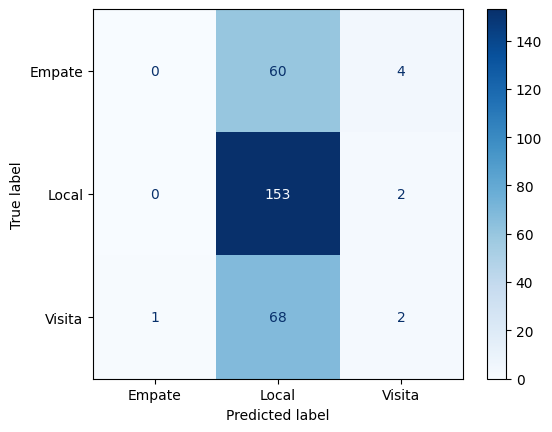

In [60]:
# Matriz de confusión del modelo con Random Forest y Binary Encoding.
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=clf_be.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
# Calcular el f1_score para cada posible resultado.
f1_score(y_test, y_hat, average=None)

array([0.        , 0.70183486, 0.05063291])

#### **Guardado del dataframe como archivo csv y exportación del modelo**.
##### *Binary Encoder + Random Forest Classifier*

In [62]:
# Guardado como archivo csv del dataframe final codificado con One Hot Encoder.
dataframe_be_final.to_csv('mundiales_binaryencoder.csv')
# Exportación del clasificador Random Forest Classifier.
pickle.dump(clf_be, open('mundiales_binaryencoder_rfc.pkl', 'wb'))